In [30]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.category import UnitData
import matplotlib.colors as colors
import math

In [31]:
def filter_to_decrease_nums(years, time_classes):
    """
    Filters out data points (year and time class) that don't have monotonically 
    decreasing time class.
    """
    new_years = []
    new_time_classes = []
    
    curr_lowest = float('inf')
    for i, num in enumerate(time_classes):
        if num < curr_lowest:
            new_years.append(years[i])
            new_time_classes.append(num)
            curr_lowest = num
            
    return new_years, new_time_classes

In [32]:
def clean_data():
    """
    Go through datastructures.csv and filter out irrelevant/incomplete data structures.
    """
    dataframe = pd.read_csv('Analysis/datastructures2.csv')
    dataframe = dataframe.replace(np.nan, '', regex=True)
#     dataframe = dataframe.drop('Domain', axis=1)
#     dataframe = dataframe.rename(columns={"Domain.1": "Domain"})
    
    dataframe = dataframe[
#                           (dataframe['Time Complexity Class'] != '#VALUE!') &
#                           (dataframe['Space Complexity Class'] != '#VALUE!') &
                          (dataframe["Looked at?"] != 0.001) &
                          (dataframe["Looked at?"] != 0.0) &
                          (dataframe["Year"] != "?") &
                          (dataframe["Year"] != "")
#                           (dataframe["Exact Problem Statement?"] == 1)
                        ]

    # Get rid of parallel, quantum, and approximate algorithms
#     dataframe = dataframe[(dataframe["Quantum?"] == 0) | (dataframe["Quantum?"] == "0")]
#     dataframe = dataframe[(dataframe["Parallel?"] == 0) | (dataframe["Parallel?"] == "0")]
#     dataframe = dataframe[(dataframe["Approximate?"] == 0) | (dataframe["Approximate?"] == "0")]


    dataframe.to_csv('Analysis/datastructures2.csv')
    return dataframe

In [33]:
data = clean_data()

In [34]:
ds_problems = set(data["Domain"])
#ds_problems.remove('Binary Tree')
ds_problems

{'Approximate Membership Query Filter (with delete)',
 'Approximate Membership Query Filter (without delete)',
 'Approximate Membership Query Filter (without insert or delete)',
 'Associative Array',
 'Binary Tree',
 'Binary Tree/Cryptography',
 'Double-ended Priority Queue',
 'Double-ended Priority Queue with Complementary Range Queries',
 'Hierarchical key-value store',
 'Locality Sensitive Hashing',
 'Monotone Priority Queue',
 'Nearest Neighbor Search',
 'Optimal Binary Search Tree (No Insert/Delete)',
 'Optimal Binary Search Tree (with Insert/Delete)',
 'Ordered Associative Array (Comparison)',
 'Ordered Associative Array (Non-Comparison), Large Universe',
 'Ordered Associative Array (Non-Comparison), Smaller Universe',
 'Orthogonal Range Search',
 'Orthogonal Range Search, Static',
 'Priority Queue',
 'Range Search',
 'Range Search, External Memory',
 'Rank/Select Data Structure (Static)',
 'Search Tree',
 'Spatial Data Structure',
 'String Search',
 'String Search, Online',
 'Tr

## Overall plots

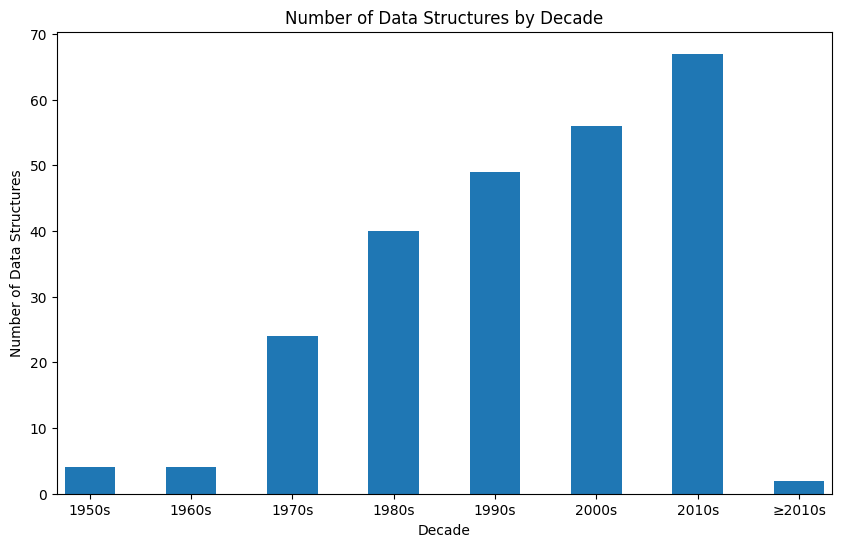

In [35]:
# Plot number of data structures by decade
ds_data = data.copy()


data.loc[data['Year'] > 2010, 'Year'] = 2010
ds_data = ds_data.groupby(ds_data['Year'] // 10 * 10).size()

# merge all year <= 1940 into 1940
#ds_data[1940] = ds_data.loc[:1940].sum()
#ds_data = ds_data.drop(ds_data.loc[:1939].index)







fig, ax = plt.subplots()

bar_container = ax.bar(ds_data.index, ds_data.values, width=5)

# set figure size
fig.set_size_inches(10, 6)

plt.margins(x=0.01)



ax.set_xticks(ds_data.index)
ax.set_xticklabels([str(year) + 's' for year in ds_data.index[:-1]]+["≥2010s"])

ax.set_xlabel('Decade')
ax.set_ylabel('Number of Data Structures')
ax.set_title('Number of Data Structures by Decade')
plt.show()

In [36]:
ds_data = data.copy()

cols = ['Space Class', 'Build Runtime Class', 'Insert Runtime Class', 'Delete Runtime Class', 
        'Find Runtime Class', 'Successor/Predecessor Runtime Class', 'Union Runtime Class', 'Min/Max Runtime Class', 
        'Increase-Key/Update Runtime Class', 'Push Runtime Class', 'Pop Most Recent Runtime Class', 'Pop Oldest Runtime Class',
        'Nearest Neighbor Runtime Class', 'Range Search Runtime Class', 'Query Runtime Class']

for col in cols:
    # Extract complete numbers from the string including the decimal part
    ds_data[col] = pd.to_numeric(ds_data[col].astype(str).str.extract(r'(\d+\.\d+|\d+)')[0], errors='coerce')
    ds_data[col] = ds_data[col].replace(0, 99999)

# Sort the DataFrame for correct group-wise comparison
ds_data.sort_values(by=['Domain', 'Year'], inplace=True)

ds_data['Improvement'] = 0
ds_data['Tradeoff'] = 0
# Identify improvements and tradeoffs
def identify_improvements(group):
    # Ensure necessary columns are present
    if not all(col in group.columns for col in cols):
        raise ValueError("Missing one or more necessary columns")

    exists_optimal = 1
    # Initialize 'Improvement' column and 'Best_' columns safely
    group['Improvement'] = 0
    group['Tradeoff'] = 0
    for col in cols:
        group['Best_' + col] = 999999

    # Initialize best values for the first row
    for col in cols:
        group['Best_' + col].iat[0] = group[col].iat[0]
        group['Improvement'].iat[0] = 1
        group['Tradeoff'].iat[0] = 0

    # Compute best values and track improvements, along with better/equal/worse counts for tradeoffs
    exists_optimal = 1
    for i in range(1, len(group)):
        better_equal_worse = [0, 0, 0]
        for col in cols:
            previous_best = group['Best_' + col].iat[i - 1]
            current_value = group[col].iat[i]

            if current_value < previous_best:
                group['Best_' + col].iat[i] = current_value
                group['Improvement'].iat[i] = 1
                better_equal_worse[0] += 1
            else:
                group['Best_' + col].iat[i] = previous_best
            
            if current_value == previous_best:
                better_equal_worse[1] += 1
            if current_value > previous_best:
                better_equal_worse[2] += 1

        if better_equal_worse[2] == 0: #this one is at least optimal in all operations + space
            exists_optimal = 1
        else:
            if exists_optimal == 1 and better_equal_worse[0] != 0: #now there exists tradeoff
                exists_optimal = 0
        
        if exists_optimal == 0:
            group['Tradeoff'].iat[i] = 1


    # Drop helper columns
    drop_cols = ['Best_' + col for col in cols]
    group.drop(columns=drop_cols, inplace=True)

    return group


ds_data = ds_data.groupby(['Domain']).apply(identify_improvements)

ds_data['Improvement'] = ds_data['Improvement'].astype(int)

ds_data.to_csv('Analysis/datastructures2_withimprovements.csv')

ds_data

/var/folders/lx/jxx7wnmn4q5g51lkvkx6hndc0000gn/T/ipykernel_3085/1461503523.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '5.99' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  group['Best_' + col].iat[0] = group[col].iat[0]
/var/folders/lx/jxx7wnmn4q5g51lkvkx6hndc0000gn/T/ipykernel_3085/1461503523.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '5.99' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  group['Best_' + col].iat[0] = group[col].iat[0]
/var/folders/lx/jxx7wnmn4q5g51lkvkx6hndc0000gn/T/ipykernel_3085/1461503523.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '5.99' has dtype incompatible with int64, please explicitly cast to a compatible d

Unnamed: 0.24  \
Domain                                                                 
Approximate Membership Query Filter (with delete) 215            215   
                                                  222            222   
                                                  216            216   
                                                  229            229   
                                                  217            217   
...                                                              ...   
Unordered Associative Array                       40              40   
                                                  42              42   
                                                  44              44   
                                                  43              43   
                                                  45              45   

                                                       Unnamed: 0.23  \
Domain                                                                 
Approximate Membership Query Filter (with delete) 215            215   
                                                  222            222   
                                                  216            216   
                                                  229            229   
                                                  217            217   
...                                                              ...   
Unordered Associative Array                       40              40   
                                                  42              42   
                                                  44              44   
                                                  43              43   
                                                  45              45   

                                                       Unnamed: 0.22  \
Domain                                                                 
Approximate Membership Query Filter (with delete) 215            215   
                                                  222            222   
                                                  216            216   
                                                  229            229   
                                                  217            217   
...                                                              ...   
Unordered Associative Array                       40              40   
                                                  42              42   
                                                  44              44   
                                                  43              43   
                                                  45              45   

                                                       Unnamed: 0.21  \
Domain                                                                 
Approximate Membership Query Filter (with delete) 215            215   
                                                  222            222   
                                                  216            216   
                                                  229            229   
                                                  217            217   
...                                                              ...   
Unordered Associative Array                       40              40   
                                                  42              42   
                                                  44              44   
                                                  43              43   
                                                  45              45   

                                                       Unnamed: 0.20  \
Domain                                                                 
Approximate Membership Query Filter (with delete) 215            215   
                                                  222            222   
                   

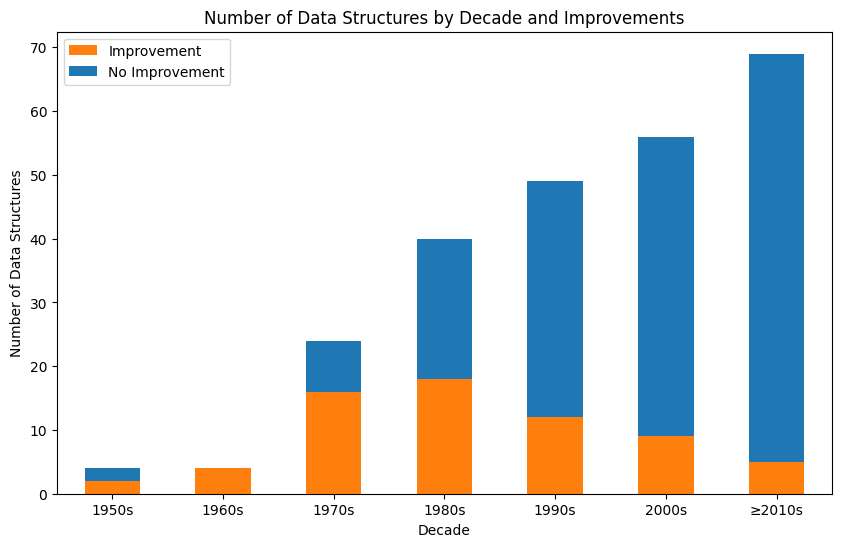

In [60]:
# Plot number of data structures by decade and improvements
data = ds_data.copy()

#data.loc[data['Year'] < 1930, 'Year'] = 1930
data.loc[data['Year'] > 2019, 'Year'] = 2019
data = data.groupby([data['Year'] // 10 * 10, 'Improvement']).size().unstack().fillna(0)
data[0], data[1] = data[1], data[0]

fig, ax = plt.subplots()
data.plot(kind='bar', stacked=True, ax=ax, color = ['tab:orange', 'tab:blue'])
# set figure size
fig.set_size_inches(10, 6)
plt.xticks(rotation=0)

plt.margins(x=0.01)

ax.set_xlabel('Decade')
ax.set_xticklabels([str(year) + 's' for year in data.index[:-1]]+["≥2010s"])

ax.set_ylabel('Number of Data Structures')
ax.set_title('Number of Data Structures by Decade and Improvements')

# legent for the plot
plt.legend(['Improvement', 'No Improvement'])

plt.show()

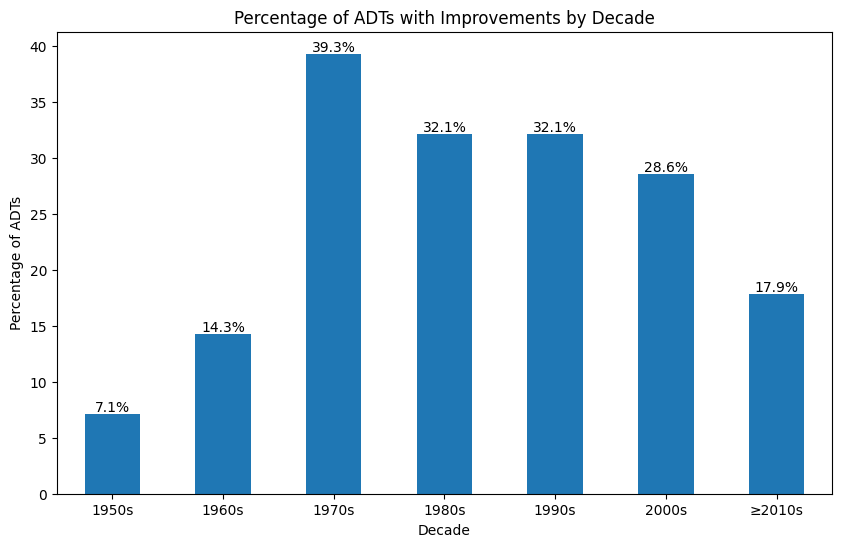

In [38]:
# Plot number of improvements by Domain by decade
data = ds_data.copy()

#data.loc[data['Year'] < 1940, 'Year'] = 1940
data.loc[data['Year'] > 2019, 'Year'] = 2019

# remove "smaller universe" version
data = data[data['Domain'] != 'Ordered Associative Array (Non-Comparison), Smaller Universe']

# drop column Family Name
data = data.drop(columns=['Domain'])
data = data[data['Improvement'] == 1]

# group by domain
data = data.groupby(['Year', 'Domain']).size().unstack().fillna(0)

data = data.groupby(data.index // 10 * 10).sum()
# if value > 0, set value to 1
data = data.map(lambda x: 1 if x > 0 else 0)

# group by decade

# sum all domains
data['Total'] = data.sum(axis=1)/28*100


# plot total per decade
fig, ax = plt.subplots()
data['Total'].plot(kind='bar', stacked=True, ax=ax)
# set figure size

for i, v in enumerate(data['Total']):
    ax.text(i, v+0.2, f'{v:.1f}%', ha='center')

fig.set_size_inches(10, 6)
plt.xticks(rotation=0)

plt.margins(x=0.01)

ax.set_xlabel('Decade')
ax.set_xticklabels([str(year) + 's' for year in data.index[:-1]]+["≥2010s"])

ax.set_ylabel('Percentage of ADTs')
ax.set_title('Percentage of ADTs with Improvements by Decade')
plt.show()

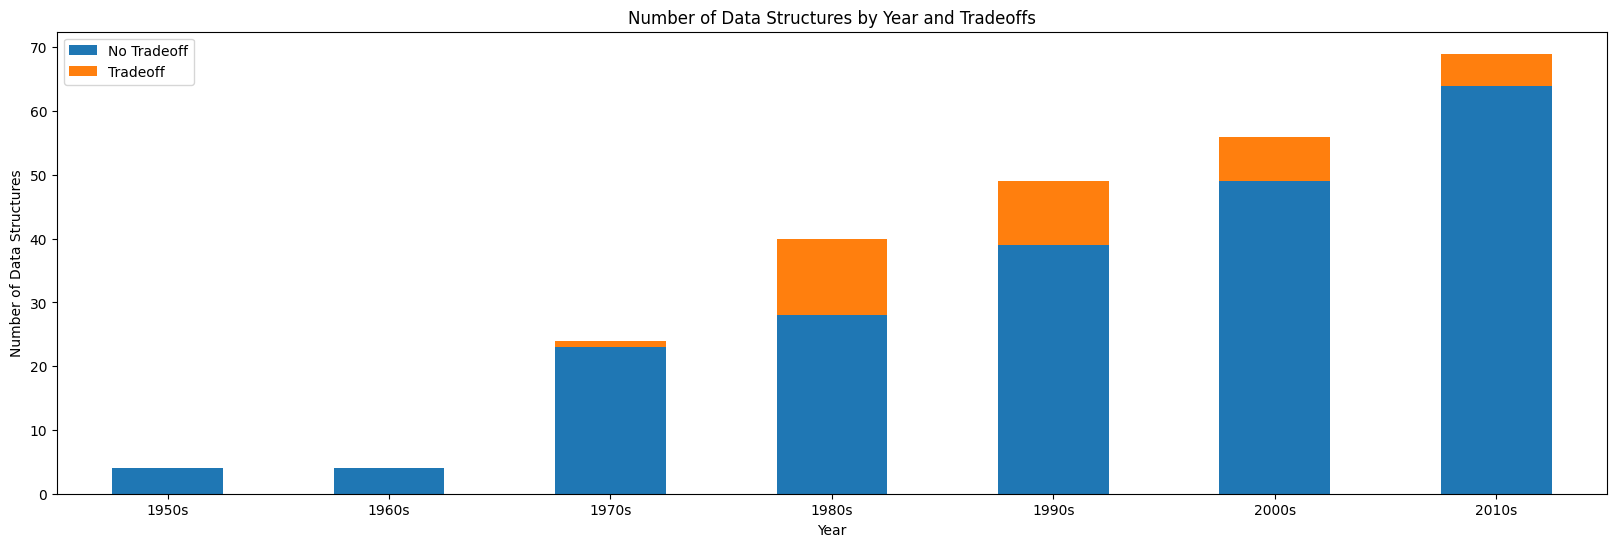

In [39]:
# Plot number of data structures by decade and tradeoffs
data = ds_data.copy()

#data.loc[data['Year'] < 1930, 'Year'] = 1930
data.loc[data['Year'] > 2019, 'Year'] = 2019
data = data.groupby([data['Year'] // 10 * 10, 'Tradeoff']).size().unstack().fillna(0)

fig, ax = plt.subplots()
data.plot(kind='bar', stacked=True, ax=ax)
# set figure size
fig.set_size_inches(20, 6)
plt.xticks(rotation=0)

plt.margins(x=0.01)

ax.set_xlabel('Year')
ax.set_xticklabels([str(year) + 's'  for year in data.index])

ax.set_ylabel('Number of Data Structures')
ax.set_title('Number of Data Structures by Year and Tradeoffs')

# legent for the plot
plt.legend(['No Tradeoff', 'Tradeoff'])

plt.show()

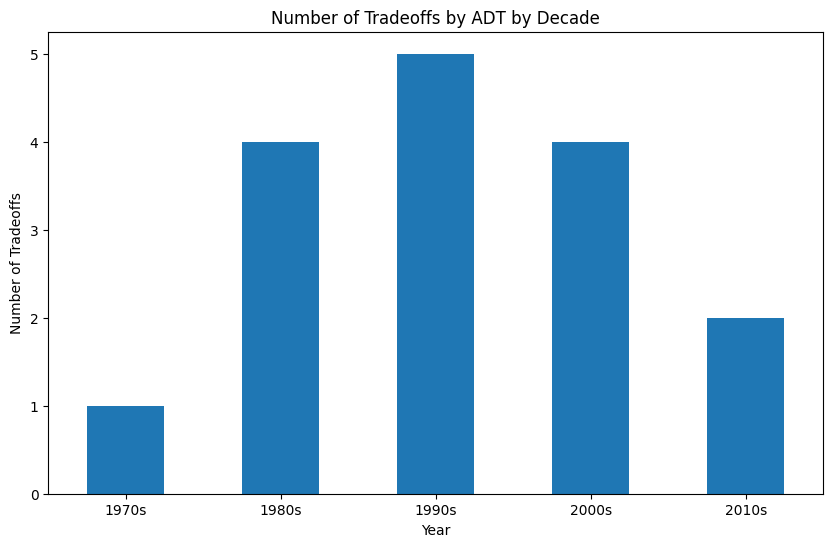

In [40]:
# Plot number of tradeoffs by Domain by decade
data = ds_data.copy()

#data.loc[data['Year'] < 1940, 'Year'] = 1940
data.loc[data['Year'] > 2019, 'Year'] = 2019


# drop column Family Name
data = data.drop(columns=['Domain'])
data = data[data['Tradeoff'] == 1]

# group by domain
data = data.groupby(['Year', 'Domain']).size().unstack().fillna(0)

data = data.groupby(data.index // 10 * 10).sum()
# if value > 0, set value to 1
data = data.map(lambda x: 1 if x > 0 else 0)

# group by decade

# sum all domains
data['Total'] = data.sum(axis=1)


# plot total per decade
fig, ax = plt.subplots()
data['Total'].plot(kind='bar', stacked=True, ax=ax)
# set figure size

fig.set_size_inches(10, 6)
plt.xticks(rotation=0)

plt.margins(x=0.01)

ax.set_xlabel('Year')
ax.set_xticklabels([str(year) + 's'  for year in data.index])

ax.set_ylabel('Number of Tradeoffs')
ax.set_title('Number of Tradeoffs by ADT by Decade')
plt.show()

In [41]:
data = ds_data.copy()

#data.loc[data['Year'] < 1940, 'Year'] = 1940


# drop column Family Name
data = data.drop(columns=['Domain'])
#data = data[data['Tradeoff'] == 1]

data = data[data['Improvement'] == 1]
data.groupby(['Domain']).size()

#data

Domain
Approximate Membership Query Filter (with delete)                 1
Approximate Membership Query Filter (without delete)              1
Approximate Membership Query Filter (without insert or delete)    1
Associative Array                                                 2
Binary Tree                                                       1
Binary Tree/Cryptography                                          1
Double-ended Priority Queue                                       2
Double-ended Priority Queue with Complementary Range Queries      1
Hierarchical key-value store                                      1
Locality Sensitive Hashing                                        1
Monotone Priority Queue                                           5
Nearest Neighbor Search                                           4
Optimal Binary Search Tree (No Insert/Delete)                     2
Optimal Binary Search Tree (with Insert/Delete)                   2
Ordered Associative Array (Comparison)   

/var/folders/lx/jxx7wnmn4q5g51lkvkx6hndc0000gn/T/ipykernel_3085/2996416614.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(val) + '%'  for val in [0, 2, 4, 6, 8, 10, 12, 14]])


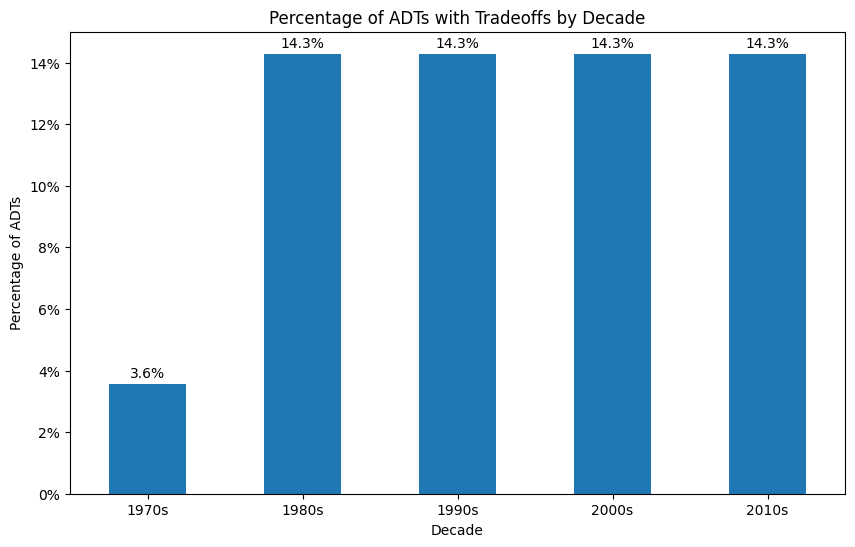

In [42]:
df = pd.DataFrame({'Tradeoff': [1/28, 4/28, 4/28, 4/28, 4/28]},
                   index=([1970, 1980, 1990, 2000, 2010]))

percentage = df['Tradeoff'] * 100

fig, ax = plt.subplots()
percentage.plot(kind='bar', stacked=True, ax=ax)
# set figure size

fig.set_size_inches(10, 6)
plt.xticks(rotation=0)

plt.margins(x=0.01)

ax.set_xlabel('Decade')
ax.set_xticklabels([str(year) + 's'  for year in df.index])
ax.set_yticklabels([str(val) + '%'  for val in [0, 2, 4, 6, 8, 10, 12, 14]])

for i, v in enumerate(percentage):
    ax.text(i, v+0.2, f'{v:.1f}%', ha='center')

ax.set_ylabel('Percentage of ADTs')
ax.set_title('Percentage of ADTs with Tradeoffs by Decade')
plt.show()

In [43]:
data = ds_data.copy()

#data.loc[data['Year'] < 1940, 'Year'] = 1940

data = data[data['Domain'] == 'Priority Queue']
data.sort_values('Year')

data.to_csv('Analysis/priorityqueue.csv')

data

Unnamed: 0.24  Unnamed: 0.23  Unnamed: 0.22  \
Domain                                                            
Priority Queue 66              66             66             66   
               68              68             68             68   
               67              67             67             67   
               70              70             70             70   
               92              92             92             92   
               103            103            103            103   
               74              74             74             74   
               86              86             86             86   
               87              87             87             87   
               71              71             71             71   
               72              72             72             72   
               73              73             73             73   
               88              88             88             88   
               94              94             94             94   
               98              98             98             98   
               99              99             99             99   
               100            100            100            100   
               101            101            101            101   
               76              76             76             76   
               69              69             69             69   
               95              95             95             95   
               82              82             82             82   
               83              83             83             83   
               102            102            102            102   
               85              85             85             85   
               96              96             96             96   
               97              97             97             97   
               84              84             84             84   
               77              77             77             77   
               78              78             78             78   
               75              75             75             75   
               79              79             79             79   
               80              80             80             80   
               81              81             81             81   
               89              89             89             89   
               90              90             90             90   
               91              91             91             91   
               93              93             93             93   

                    Unnamed: 0.21  Unnamed: 0.20  Unnamed: 0.19  \
Domain                                                            
Priority Queue 66              66             66             66   
               68              68             68             68   
               67              67             67             67   
               70              70             70             70   
               92              92             92             92   
               103            103            103            103   
               74              74             74             74   
               86              86             86             86   
               87              87             87             87   
               71              71             71             71   
               72              72             72             72   
               73              73             73             73   
               88              88             88             88   
               94              94             94             94   
               98              98             98             98   
               99              99             99             99   
               100            100            100            100   
               101            101            101            101   